# Introduction to Swarm access through VirES

> Authors: Ashley Smith
>
> Abstract: VirES is a server/client architecture to help access time series of Swarm data and models. Access is enabled through a token generated on the website, and a Python package, viresclient, which provides the connection with the Python ecosystem (e.g. xarray).

In [1]:
# Display important package versions used
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

2020-05-21T11:53:50+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.6.1
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2


**VirES** (Virtual environments for Earth Scientists) is a platform for data & model access, analysis, and visualisation for ESA's magnetic mission, **Swarm**

This tutorial introduces the Python interface to VirES, **`viresclient`**. We demonstrate usage of the primary Swarm magnetic dataset (`SW_OPER_MAGA_LR_1B`) and geomagnetic field models produced as part of the Swarm mission. Some knowledge of `pandas` and `matplotlib` is assumed.

Run this on the **[VRE](https://vre.vires.services/)** (Virtual Research Environment), where viresclient is already installed, or [check the instructions](https://viresclient.readthedocs.io/en/latest/installation.html) to set it up on your own Python environment.

For more information see:
- https://vires.services/ (Web interface)
- https://viresclient.readthedocs.io (Python interface)
- https://swarm-vre.readthedocs.io/ (Virtual Research Environment / JupyterLab)
- https://earth.esa.int/eogateway/missions/swarm (Swarm mission)

### 0. Configuration

In order to authenticate access to the VirES server, `viresclient` requires an access token - this ties communications between the server and the client to your account. **If you are using the VRE, this is handled automatically so you can skip this step.**

If you are running `viresclient` on a different machine, you will need to follow these instructions:

1. Create a user account at https://vires.services if you haven't already done so
2. Install viresclient in your Python environment - see https://viresclient.readthedocs.io/en/latest/installation.html
3. Create a new code cell here and execute the following:

   ```python
   from viresclient import set_token
   set_token("https://vires.services/ows", set_default=True)
   ```


4. You will now be directed to the [VirES token management page](https://vires.services/accounts/tokens/), and prompted to generate a new token and enter it here

Your access token should now have been saved to your environment and you won't need to provide it again. The token and its associated access URL are stored in a file: `~/.viresclient.ini` (this file can also be edited directly). You may generate and set a new token, or revoke old tokens, at any point. These are similar to passwords, so **should be kept secret** - if you accidentally leak a token, you can revoke it at the token management page and generate a new one. It is also possible to set access tokens via CLI. For more information, see https://viresclient.readthedocs.io/en/latest/config_details.html

### 1. Fetching some data

Import the `SwarmRequest` object which provides the VirES interface, and `datetime` which gives convenient time objects which can be used by `SwarmRequest.get_between()`

In [2]:
from viresclient import SwarmRequest
import datetime as dt

The following code will fetch one day (i.e. around 15 orbits) of the scalar (`F`) measurements from Swarm Alpha. 

Several keyword arguments can be provided to `.set_products()` to specify the type of data you want. The `measurements` available depend on the collection chosen in `.set_collection()`. The same set of `auxiliaries` are available for all collections - here we also choose to fetch the `MLT` - magnetic local time.

`sampling_step="PT10S"` downsamples the data to 10 seconds, from the `MAGx_LR` default of 1 second. If no `sampling_step` is provided, the data will be accessed in its original form (i.e. here, 1-second sampling). These strings to choose the `sampling_step` should be provided as [ISO 8601 durations](https://en.wikipedia.org/wiki/ISO_8601#Durations) (e.g. `"PT1M"` for 1-minute sampling).

`start_time` and `end_time` in `.get_between()` together provide the time window you want to fetch data for - executing this line causes the request to be processed on the server and the data returned to you. NB: this returns data *up to but not including* `end_time`. Alternatively we can provide the start and end times as ISO_8601 strings.

In [3]:
# Set up connection with server
request = SwarmRequest()
# Set collection to use
request.set_collection("SW_OPER_MAGA_LR_1B")
# Set mix of products to fetch:
#   measurements (variables from the given collection)
#   models (magnetic model predictions at spacecraft sampling points)
#   auxiliaries (variables available with any collection)
# Also set additional configuration such as:
#   sampling_step
request.set_products(
    measurements=["F"],
    sampling_step="PT10S",
    auxiliaries=["MLT"]
)
# Fetch data from a given time interval
data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.428MB)


The data is now contained within the object which we called `data`:

In [4]:
data

The data is temporarily stored on disk and not yet loaded into memory - the `ReturnedData` object is actually a wrapper around a temporary CDF file which could be written to disk directly:

In [5]:
data.to_file("test_file.cdf", overwrite=True)

Data written to test_file.cdf


... but it is possible to directly transfer it to a `pandas.DataFrame` object:

In [6]:
df = data.as_dataframe()
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Longitude,Radius,Spacecraft,Latitude,F,MLT
Timestamp,,,,,,
2016-01-01 00:00:00,92.793967,6833853.08,A,-72.499224,46935.8083,1.732929
2016-01-01 00:00:10,93.091639,6833864.74,A,-73.130685,46908.3246,1.506584
2016-01-01 00:00:20,93.414902,6833875.98,A,-73.761537,46878.3804,1.263233
2016-01-01 00:00:30,93.766833,6833886.81,A,-74.391708,46846.0555,1.002926
2016-01-01 00:00:40,94.151014,6833897.24,A,-75.021114,46811.5549,0.726345


... or a `xarray.Dataset`:

In [7]:
ds = data.as_xarray()
print(type(ds))
ds

<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:     (Timestamp: 8640)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    MLT         (Timestamp) float64 1.733 1.507 1.263 ... 17.16 17.16 17.16
    Longitude   (Timestamp) float64 92.79 93.09 93.41 ... -95.37 -95.37 -95.37
    Radius      (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06 6.823e+06
    Latitude    (Timestamp) float64 -72.5 -73.13 -73.76 ... 29.82 30.46 31.1
    F           (Timestamp) float64 4.694e+04 4.691e+04 ... 3.83e+04 3.861e+04
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20160101T000000_20160101T235959_050...
    MagneticModels:  []
    RangeFilters:    []

Try plotting some things to visualise the data. The following shows the variation in field strength measured by the satellite as it passes between high and low latitudes, varying from one orbit to the next as it samples a different longitude.

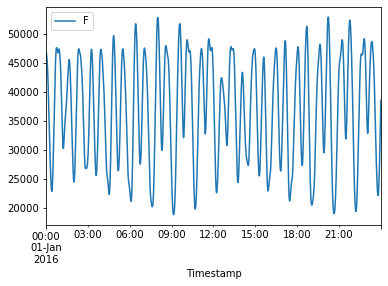

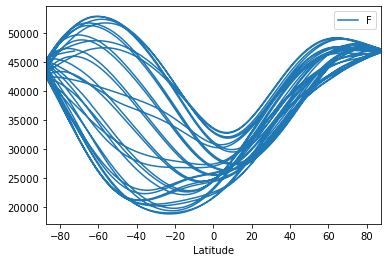

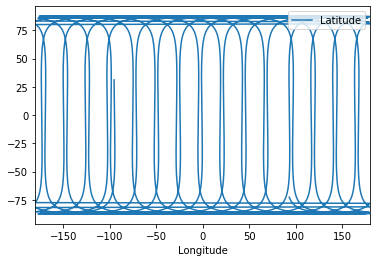

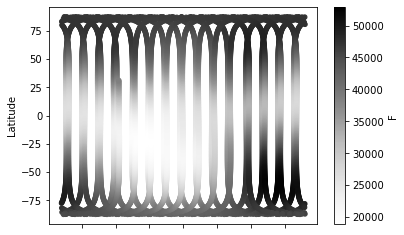

In [8]:
df.plot(y="F")
df.plot(y="F", x="Latitude")
df.plot(y="Latitude", x="Longitude")
df.plot(y="Latitude", x="Longitude", c="F", kind="scatter");

### 2. Fetching model evaluations at the same time

Various (spherical harmonic) [models of the geomagnetic field](https://magneticearth.org/pages/models.html) are produced as Swarm mission products and these are available through VirES. They are evaluated on demand at the same points and times as the data sample points. Here we ask for the `MCO_SHA_2D` model, a dedicated core field model produced from Swarm data. By supplying `residuals=True` we will get the data-model residuals, named in the dataframe as `F_res_MCO_SHA_2D`.

In [9]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F"],
    models=["MCO_SHA_2D"],
    residuals=True,
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

df = data.as_dataframe()
df.head()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.359MB)


,Longitude,Radius,Spacecraft,Latitude,F_res_MCO_SHA_2D
Timestamp,,,,,
2016-01-01 00:00:00,92.793967,6833853.08,A,-72.499224,111.980426
2016-01-01 00:00:10,93.091639,6833864.74,A,-73.130685,108.278648
2016-01-01 00:00:20,93.414902,6833875.98,A,-73.761537,104.358770
2016-01-01 00:00:30,93.766833,6833886.81,A,-74.391708,100.296102
2016-01-01 00:00:40,94.151014,6833897.24,A,-75.021114,96.294332


The core field has been removed from the data so the amplitudes are much smaller. Can you interpret the new signals in terms of external fields, i.e. from the ionosphere and magnetosphere?

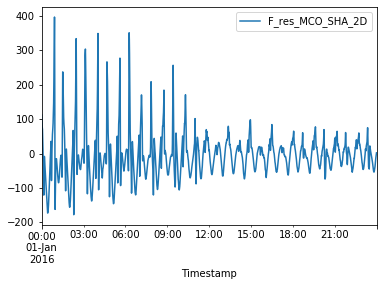

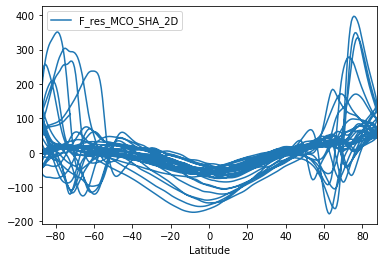

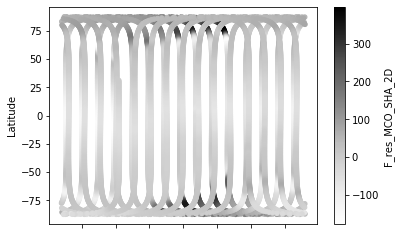

In [10]:
df.plot(y="F_res_MCO_SHA_2D")
df.plot(y="F_res_MCO_SHA_2D", x="Latitude")
df.plot(y="Latitude", x="Longitude", c="F_res_MCO_SHA_2D", kind="scatter");

### 3. More complex model handling

We can also remove a magnetospheric field model at the same time, by specifying a new model (which we call `MCO_MMA` here, but can be named whatever you like) which is the sum of core and magnetospheric models.

> See [Swarm_notebooks/02b__viresclient-Available-Data](https://swarm-vre.readthedocs.io/en/latest/Swarm_notebooks/02b__viresclient-Available-Data.html) for more examples of this - it is also possible to specify the spherical harmonic degrees (min/max) to use, and to provide your own `.shc` model.

The remaining signal is now primarily due to the ionosphere.

Note that here we are instead using the CI (comprehensive inversion) core and magnetosphere models (indicated by `2C` in the product names). The magnetospheric model (`MMA`) is split into two parts - "primary": external to the Earth, and "secondary": the induced counterpart internal to the Earth.

In [11]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F"],
    models=["MCO_MMA = 'MCO_SHA_2C' + 'MMA_SHA_2C-Primary' + 'MMA_SHA_2C-Secondary'"],
    residuals=True,
    sampling_step="PT10S",
    auxiliaries=["MLT"]
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

df = data.as_dataframe()
df.head()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:04, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.429MB)


,Longitude,Radius,Spacecraft,Latitude,F_res_MCO_MMA,MLT
Timestamp,,,,,,
2016-01-01 00:00:00,92.793967,6833853.08,A,-72.499224,81.000383,1.732929
2016-01-01 00:00:10,93.091639,6833864.74,A,-73.130685,76.969177,1.506584
2016-01-01 00:00:20,93.414902,6833875.98,A,-73.761537,72.725595,1.263233
2016-01-01 00:00:30,93.766833,6833886.81,A,-74.391708,68.338631,1.002926
2016-01-01 00:00:40,94.151014,6833897.24,A,-75.021114,64.005573,0.726345


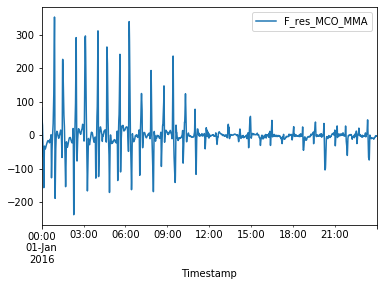

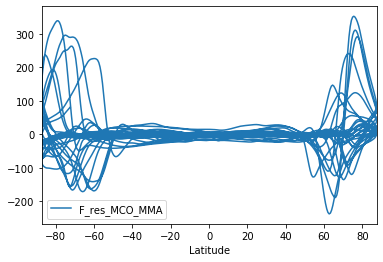

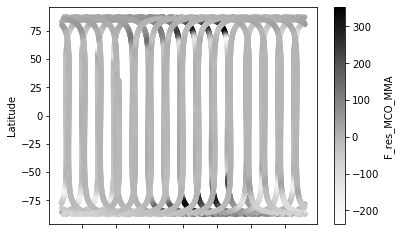

In [12]:
df.plot(y="F_res_MCO_MMA")
df.plot(y="F_res_MCO_MMA", x="Latitude")
df.plot(y="Latitude", x="Longitude", c="F_res_MCO_MMA", kind="scatter");